## 1. Omniglot download

In [1]:
import os
try:
    from google_drive_downloader import GoogleDriveDownloader as gdd
except ModuleNotFoundError:
    !pip install googledrivedownloader
    from google_drive_downloader import GoogleDriveDownloader as gdd
    print("import google_drive_downloader...!")
# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

import google_drive_downloader...!
Unzipping...Done.


### 2. Helper function & Datagenerator class

In [7]:
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc
import matplotlib.pyplot as plt


def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
        
    ## If you are using google colab, you need to use this code!   
    #images_labels = [(i, os.path.join(path, image.decode('UTF-8')))
    #                 for i, path in zip(labels, paths)
    #                 for image in sampler(os.listdir(path))]
    
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    import imageio
    image = imageio.imread(filename)  # misc.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size, shuffle=False):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        folders = np.array(folders)
        all_image_batches = np.empty([batch_size, self.num_samples_per_class, self.num_classes, self.dim_input])
        all_label_batches = np.empty([batch_size, self.num_samples_per_class,self.num_classes, self.num_classes])

        for b in range(batch_size):
            sampled_class_folders = folders[random.sample(range(len(folders)) , self.num_classes)]
            labels = np.arange(self.num_classes)
            labels_images = get_images(sampled_class_folders, labels, nb_samples=self.num_samples_per_class, shuffle=False)
            for i, (label, img_path) in enumerate(labels_images):
                k = i % self.num_samples_per_class
                img = image_file_to_array(img_path, self.dim_input).flatten()
                all_image_batches[b,k,label,:] = img

                one_hot = np.eye(self.num_classes)[label]
                all_label_batches[b,k,label, :] = one_hot

            indices_along_N = np.arange(self.num_classes)
            np.random.shuffle(indices_along_N)
            all_image_batches[:,-1,:,:] = all_image_batches[:,-1,indices_along_N,:]
            all_label_batches[:,-1,:,:] = all_label_batches[:,-1,indices_along_N,:]
        #############################

        return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)


## 3. Data preprocessing for few-shot classification
#### shuffle: False

In [8]:
num_classes=5
num_samples_per_class=3

data = DataGenerator(num_classes, num_samples_per_class)

images, labels = data.sample_batch('train', batch_size=2, shuffle=False)
print("Batch of images of shape:", images.shape)
print("Batch of labels of shape:", labels.shape)
for i in range(num_classes):
    print(labels[0,0,i])

Batch of images of shape: (2, 3, 5, 784)
Batch of labels of shape: (2, 3, 5, 5)
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]


####################
meta-batch 0: 
####################


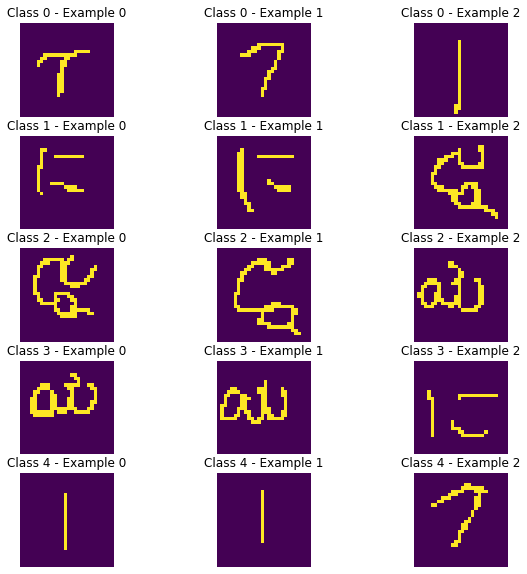

####################
meta-batch 1: 
####################


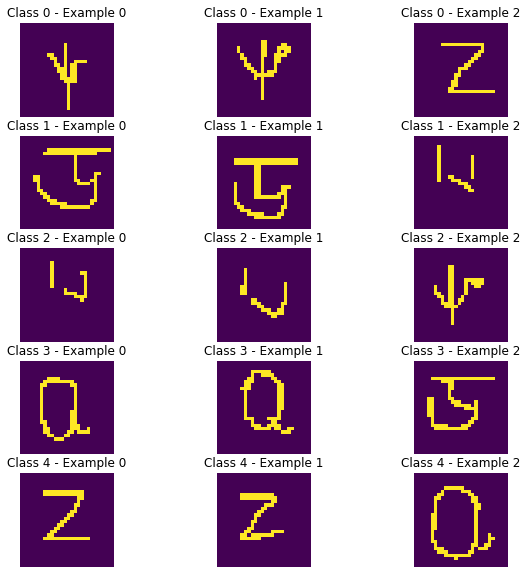

In [9]:
for b in range(len(images)): # batch size
    print("#"*20)
    print("meta-batch {}: ".format(b))
    print("#"*20)
    count = 0
    fig = plt.figure(figsize=(10, 10))
    for cl in range(num_classes): # n-way
        for sa in range(num_samples_per_class): # k-shot
            plt.subplot(num_classes, num_samples_per_class, count + 1)
            plt.title("Class {} - Example {}".format(cl, sa))
            image = images[b, sa, cl].reshape((28,28))
            plt.imshow(image)
            plt.axis('off');
            count += 1
    plt.show()

#### Shuffle: True

In [10]:
num_classes=5
num_samples_per_class=3

data = DataGenerator(num_classes, num_samples_per_class)

images, labels = data.sample_batch('train', batch_size=2, shuffle=True)
print("Batch of images of shape:", images.shape)
print("Batch of labels of shape:", labels.shape)
for i in range(num_classes):
    print(labels[0,0,i])

Batch of images of shape: (2, 3, 5, 784)
Batch of labels of shape: (2, 3, 5, 5)
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]


####################
meta-batch 0: 
####################


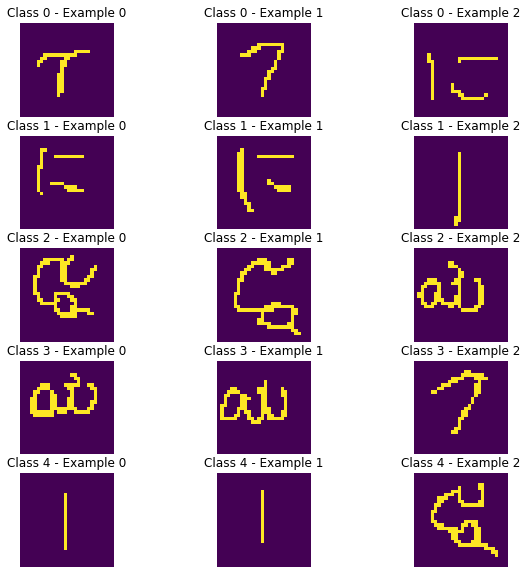

####################
meta-batch 1: 
####################


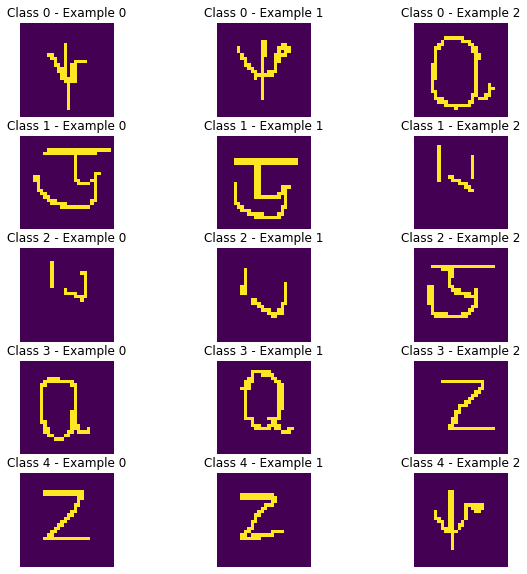

In [11]:
for b in range(len(images)): # batch size
    print("#"*20)
    print("meta-batch {}: ".format(b))
    print("#"*20)
    count = 0
    fig = plt.figure(figsize=(10, 10))
    for cl in range(num_classes): # n-way
        for sa in range(num_samples_per_class): # k-shot
            plt.subplot(num_classes, num_samples_per_class, count + 1)
            plt.title("Class {} - Example {}".format(cl, sa))
            image = images[b, sa, cl].reshape((28,28))
            plt.imshow(image)
            plt.axis('off');
            count += 1
    plt.show()